# Project Title: Anomaly Detection in Checking Accounts

## 1. Project Overview  
This project aims to detect suspicious transactions in checking accounts using deep learning and machine learning techniques. We employ an LSTM-based autoencoder and Isolation Forest to identify anomalies by modeling normal transaction behavior and detecting deviations.

## 2. Data and Preprocessing  
- Transaction data includes fields such as timestamp, description, amount, and transaction type.  
- Temporal features such as `hour`, `dayofweek`, and time interval (`time_diff`) were extracted.  
- Amounts were normalized to ensure model stability.

## 3. Models and Detection Methods  
- **Isolation Forest**: Applied first to flag potential anomalies based on feature space isolation. Results saved in `iso_pred` and `iso_anomaly`.  
- **LSTM Autoencoder**: Trained on sequences of transaction data to reconstruct normal patterns. Reconstruction error used to flag anomalies. Output includes `lstm_recon_error` and `is_anomaly`.

## 4. Visualization and Analysis  
- Time-series plot of reconstruction error  
- Distribution of anomalous transaction amounts  
- Top 10 accounts with the highest anomaly count  
- Distribution of anomalous transaction types (bar chart & pie chart)  
- Anomaly rate by transaction description (Top 15)

## 5. Preliminary Findings  
- Anomalies often appear in categories such as WITHDRAWAL and POSDEBIT.  
- A few accounts show frequent anomalies and may require further investigation.  
- Legitimate-looking transactions (e.g., PAYCHECK, VENMO) are occasionally flagged, possibly due to underrepresentation in training or model over-sensitivity.

## 6. Summary and Next Steps  
- Isolation Forest provides an initial filter for point anomalies; LSTM Autoencoder captures sequential transaction anomalies.  
- The model is currently sensitive to certain transaction types; introducing category-aware modeling or additional features may improve precision.  
- In the next phase, we will compare with other methods (e.g., Local Outlier Factor) and evaluate ensemble strategies to improve robustness.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [55]:
import pandas as pd


accounts_path = '/content/drive/MyDrive/synthetic_checking_accounts.csv'
transactions_path = '/content/drive/MyDrive/synthetic_checking_transactions.csv'


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Step 1: 数据加载与预处理

# 加载数据
accounts = pd.read_csv(accounts_path)
transactions = pd.read_csv(transactions_path, parse_dates=['transactionTimestamp'])


# 合并账户信息
merged_df = transactions.merge(accounts, on='accountId', how='left')
merged_df = merged_df.sort_values("transactionTimestamp")

# 时间特征提取
def add_time_features(df):
    df['hour'] = df['transactionTimestamp'].dt.hour
    df['dayofweek'] = df['transactionTimestamp'].dt.dayofweek
    df['time_diff'] = df.groupby('accountId')['transactionTimestamp'].diff().dt.total_seconds().fillna(0)
    return df

merged_df = add_time_features(merged_df)

# 初步选择的特征
feature_cols = ['amount', 'hour', 'dayofweek', 'time_diff']

# 归一化
scaler = MinMaxScaler()
merged_df[feature_cols] = scaler.fit_transform(merged_df[feature_cols])

In [57]:
print(merged_df[['accountId', 'transactionTimestamp', 'amount', 'nickname', 'status_x', 'status_y']].head(10))


       accountId transactionTimestamp    amount           nickname status_x  \
3484  3337623233  2022-01-01 03:05:29  0.743698  INDICATE CHECKING   POSTED   
2568  3816734163  2022-01-01 04:38:49  0.407086    FAMILY CHECKING   POSTED   
4578  3631367861  2022-01-01 05:08:31  0.327692   SOCIETY CHECKING   POSTED   
212   3455600092  2022-01-01 10:21:14  0.432587       HIT CHECKING   POSTED   
1189  3034620484  2022-01-01 13:13:56  0.352911     STORY CHECKING   POSTED   
4968  3668813180  2022-01-01 15:34:28  0.200474     THREE CHECKING   POSTED   
864   3390395520  2022-01-01 19:12:40  0.220385   USUALLY CHECKING   POSTED   
2381  3987383526  2022-01-02 02:50:07  0.039407    SIMPLY CHECKING   POSTED   
1730  3132531984  2022-01-02 07:49:13  0.242113   SURFACE CHECKING   POSTED   
3645  3793371825  2022-01-02 13:44:07  0.857855  DAUGHTER CHECKING   POSTED   

     status_y  
3484     OPEN  
2568     OPEN  
4578     OPEN  
212      OPEN  
1189     OPEN  
4968     OPEN  
864      OPEN  
23

In [58]:
# Step 2: Isolation Forest

iso_model = IsolationForest(contamination=0.02, random_state=42)
merged_df['iso_pred'] = iso_model.fit_predict(merged_df[feature_cols])
merged_df['iso_anomaly'] = (merged_df['iso_pred'] == -1).astype(int)


In [59]:
anomalies = merged_df[merged_df['iso_anomaly'] == 1]
print(anomalies[['accountId', 'transactionTimestamp', 'amount', 'hour', 'dayofweek', 'time_diff']].head())

       accountId transactionTimestamp    amount      hour  dayofweek  \
1759  3453317224  2022-03-21 14:08:59  0.995932  0.608696        0.0   
2886  3948787539  2022-04-10 22:53:45  0.948965  0.956522        1.0   
2814  3024293784  2022-04-17 17:52:25  0.803008  0.739130        1.0   
3660  3110800526  2022-05-15 08:44:27  0.814118  0.347826        1.0   
2498  3998145192  2022-05-22 01:11:30  0.342747  0.043478        1.0   

      time_diff  
1759   0.208790  
2886   0.365419  
2814   0.374520  
3660   0.296876  
2498   0.429615  


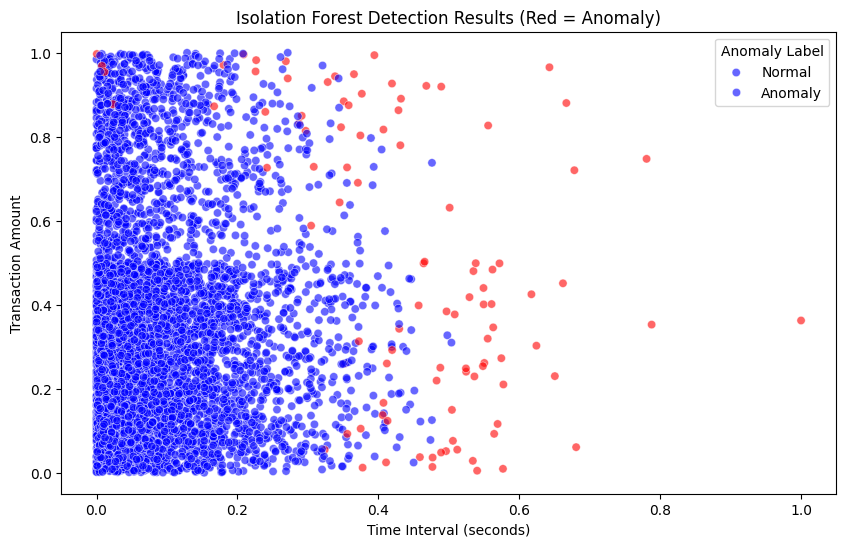

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_df,
    x='time_diff',
    y='amount',
    hue='iso_anomaly',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
plt.title("Isolation Forest Detection Results (Red = Anomaly)")
plt.xlabel("Time Interval (seconds)")
plt.ylabel("Transaction Amount")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.show()

In [61]:
# 每个用户的异常交易次数
user_anomaly_counts = merged_df.groupby('accountId')['iso_anomaly'].sum().sort_values(ascending=False)
print(user_anomaly_counts.head(100))


accountId
3006860098    3
3121174249    3
3258283488    3
3903232096    3
3214096630    2
             ..
3846035141    0
3876972146    0
3816734163    0
3985199607    0
3958010836    0
Name: iso_anomaly, Length: 100, dtype: int64


In [62]:
# Step 3: LSTM Autoencoder
from sklearn.preprocessing import MinMaxScaler

# 选择要使用的特征
sequence_features = ['amount', 'hour', 'dayofweek', 'time_diff']

# 对特征归一化（为了 LSTM 更稳定）
scaler = MinMaxScaler()
merged_df[sequence_features] = scaler.fit_transform(merged_df[sequence_features])

# 按 accountId 分组，构造固定长度的序列（填充或截断）
MAX_SEQ_LEN = 20

def build_sequences(df, group_key='accountId', seq_len=MAX_SEQ_LEN):
    sequences = []
    account_ids = []
    for acc_id, group in df.groupby(group_key):
        group = group.sort_values('transactionTimestamp')
        values = group[sequence_features].values
        if len(values) >= seq_len:
            for i in range(len(values) - seq_len + 1):
                sequences.append(values[i:i+seq_len])
                account_ids.append(acc_id)
    return np.array(sequences), account_ids

X_seq, account_seq = build_sequences(merged_df)
print(f"LSTM Input Shape: {X_seq.shape}")


LSTM Input Shape: (3100, 20, 4)


In [63]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        decoded, _ = self.decoder(hidden.repeat(x.size(1), 1, 1).permute(1,0,2))
        return decoded

# 模型超参数
input_dim = X_seq.shape[2]
hidden_dim = 32
model = LSTMAutoencoder(input_dim, hidden_dim)

# 转为 tensor
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Epoch 1, Loss: 9.1231
Epoch 2, Loss: 6.8056
Epoch 3, Loss: 6.7402
Epoch 4, Loss: 6.6720
Epoch 5, Loss: 6.5857
Epoch 6, Loss: 6.5253
Epoch 7, Loss: 6.5012
Epoch 8, Loss: 6.4806
Epoch 9, Loss: 6.4406
Epoch 10, Loss: 6.4281
Epoch 11, Loss: 6.4233
Epoch 12, Loss: 6.4201
Epoch 13, Loss: 6.4186
Epoch 14, Loss: 6.4161
Epoch 15, Loss: 6.4160
Epoch 16, Loss: 6.4147
Epoch 17, Loss: 6.4141
Epoch 18, Loss: 6.4135
Epoch 19, Loss: 6.4131
Epoch 20, Loss: 6.4124
Epoch 21, Loss: 6.4115
Epoch 22, Loss: 6.4117
Epoch 23, Loss: 6.4117
Epoch 24, Loss: 6.4114
Epoch 25, Loss: 6.4106
Epoch 26, Loss: 6.4110
Epoch 27, Loss: 6.4104
Epoch 28, Loss: 6.4108
Epoch 29, Loss: 6.4096
Epoch 30, Loss: 6.4099
Epoch 31, Loss: 6.4094
Epoch 32, Loss: 6.4091
Epoch 33, Loss: 6.4083
Epoch 34, Loss: 6.4062
Epoch 35, Loss: 6.4041
Epoch 36, Loss: 6.4028
Epoch 37, Loss: 6.4020
Epoch 38, Loss: 6.4018
Epoch 39, Loss: 6.4017
Epoch 40, Loss: 6.4016
Epoch 41, Loss: 6.4020
Epoch 42, Loss: 6.4010
Epoch 43, Loss: 6.4011
Epoch 44, Loss: 6.40

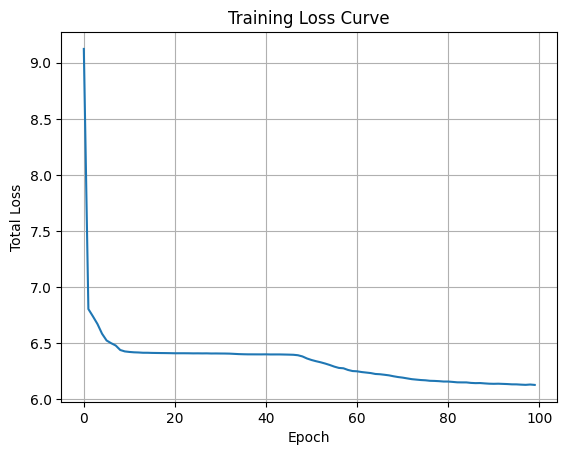

In [64]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_list = []

# 训练
for epoch in range(100):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]

        # 前向传播
        output = model(x_batch)
        loss = criterion(output, x_batch)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_list.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# 绘制损失曲线
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [65]:
# Use LSTM Autoencoder to compute reconstruction error
from torch.utils.data import TensorDataset, DataLoader

# Set the model to evaluation mode
model.eval()
reconstruction_errors = []

# Compute reconstruction error for each sequence
with torch.no_grad():
    for i in range(len(X_tensor)):
        x = X_tensor[i].unsqueeze(0)  # Add batch dimension
        output = model(x)
        loss = criterion(output, x)
        reconstruction_errors.append(loss.item())

# Trim the original DataFrame to match the number of sequences
# This assumes that X_tensor was created from merged_df using sliding windows
# So the first (len(merged_df) - len(X_tensor)) rows do not have corresponding reconstruction errors
start_idx = len(merged_df) - len(reconstruction_errors)
merged_df_trimmed = merged_df.iloc[start_idx:].copy()

# Attach reconstruction errors
merged_df_trimmed['lstm_recon_error'] = reconstruction_errors


In [66]:
import numpy as np

# Define threshold as, e.g., the 95th percentile of reconstruction error
threshold = np.percentile(reconstruction_errors, 95)

# Flag anomalies
merged_df_trimmed['is_anomaly'] = merged_df_trimmed['lstm_recon_error'] > threshold


In [67]:
print("Number of anomalies:", merged_df_trimmed['is_anomaly'].sum())


Number of anomalies: 155


In [68]:
top_anomalies = merged_df_trimmed.sort_values(by='lstm_recon_error', ascending=False).head(10)
display(top_anomalies)


,accountId,transactionId,transactionTimestamp,description,transactionType,subCategory,amount,status_x,debitCreditMemo,accountNumberDisplay,...,nickname,status_y,openedDate,hour,dayofweek,time_diff,iso_pred,iso_anomaly,lstm_recon_error,is_anomaly
2064,3958010836,9fe0ed03-e8df-40a0-82bc-212710e9f9c4,2023-07-04 08:39:32,REMOTE ONLINE DEPOSIT,DEPOSIT,Deposit,0.656281,POSTED,CREDIT,************7026,...,ALMOST CHECKING,OPEN,2017-09-04,0.347826,0.166667,0.030552,1,0,0.093897,True
681,3174162469,826a8550-62f4-4201-8fc9-511b15450985,2023-10-13 13:52:56,WAL-MART Super Center,POSDEBIT,General Merchandise,0.097899,POSTED,DEBIT,************8534,...,CONCERN CHECKING,OPEN,2017-09-13,0.565217,0.666667,0.181917,1,0,0.090374,True
4032,3756785627,3b2bd23a-bfd4-4f70-841d-76a096bd8974,2024-12-01 03:50:49,VENMO PAYMENT,WITHDRAWAL,Online payment service,0.120693,POSTED,DEBIT,************2966,...,CHILD CHECKING,OPEN,2015-10-26,0.130435,1.000000,0.057993,1,0,0.089348,True
1686,3483906586,58236faa-2814-42a9-9911-edc1b7bdf5d5,2023-07-04 16:45:19,SPECTRUM BILL,BILLPAYMENT,"Phone, Internet/Cable",0.140902,POSTED,DEBIT,************2658,...,WAY CHECKING,OPEN,2012-06-05,0.695652,0.166667,0.082539,1,0,0.088686,True
2841,3024293784,752895a6-7a32-4e6f-b1e9-475e7b894387,2023-07-04 06:03:23,VENMO PAYMENT,WITHDRAWAL,Online payment service,0.276045,POSTED,DEBIT,************3335,...,SIGNIFICANT CHECKING,OPEN,2019-01-25,0.260870,0.166667,0.089754,1,0,0.088641,True
2667,3442930865,b2fd109b-f05a-4a58-8b2a-1b2e19ac3e2a,2024-11-30 23:41:31,PAYCHECK,DIRECTDEPOSIT,Income: Paychecks/Salary,0.746184,POSTED,CREDIT,************3010,...,FOUR CHECKING,OPEN,2017-01-15,1.000000,0.833333,0.206095,1,0,0.088206,True
3453,3337623233,38032908-0ddf-4779-9292-ddaf234b20ee,2025-04-21 08:24:15,FOOD LION #2109,POSDEBIT,Groceries,0.471693,POSTED,DEBIT,************6681,...,INDICATE CHECKING,OPEN,2020-05-02,0.347826,0.000000,0.055380,1,0,0.088012,True
2681,3442930865,992a25d6-059a-4a1b-bcf7-fb3eb862be9e,2023-07-06 20:15:47,FOOD LION #2109,POSDEBIT,Groceries,0.263612,POSTED,DEBIT,************3010,...,FOUR CHECKING,OPEN,2017-01-15,0.869565,0.500000,0.050669,1,0,0.087944,True
4278,3828810327,c809c73e-bda2-4dda-b1c1-2637e842f94e,2024-12-01 13:24:41,SPECTRUM BILL,BILLPAYMENT,"Phone, Internet/Cable",0.014792,POSTED,DEBIT,************9621,...,INVESTMENT CHECKING,OPEN,2016-10-08,0.565217,1.000000,0.137706,1,0,0.087939,True
1152,3034620484,5d8e2541-544f-4615-b741-270cdc691ed9,2024-08-10 06:45:50,REMOTE ONLINE DEPOSIT,DEPOSIT,Deposit,0.732770,POSTED,CREDIT,************2228,...,STORY CHECKING,OPEN,2019-12-28,0.260870,0.833333,0.123537,1,0,0.087532,True


In [69]:
merged_df_trimmed.to_csv("lstm_anomaly_results.csv", index=False)


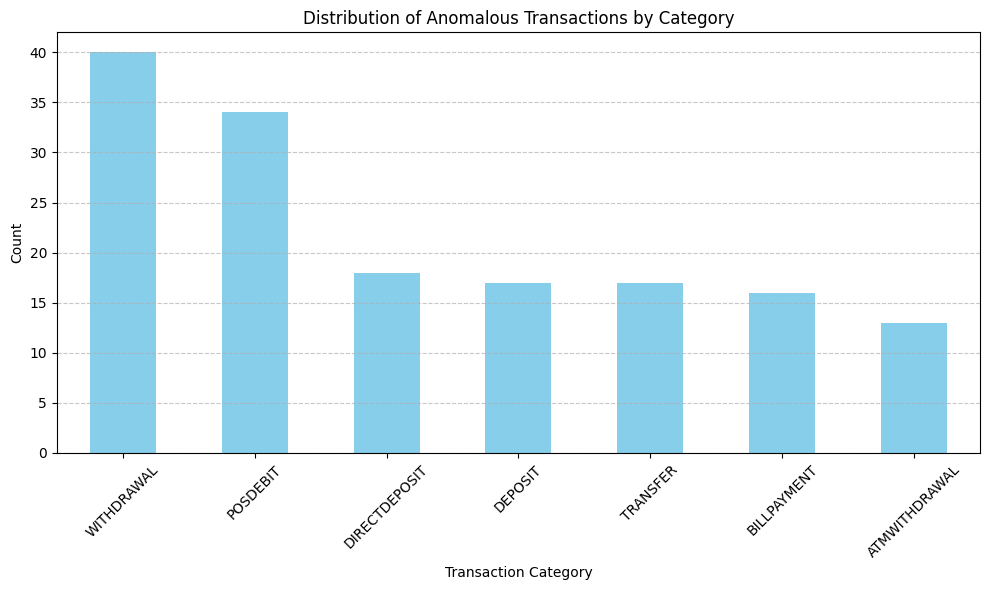

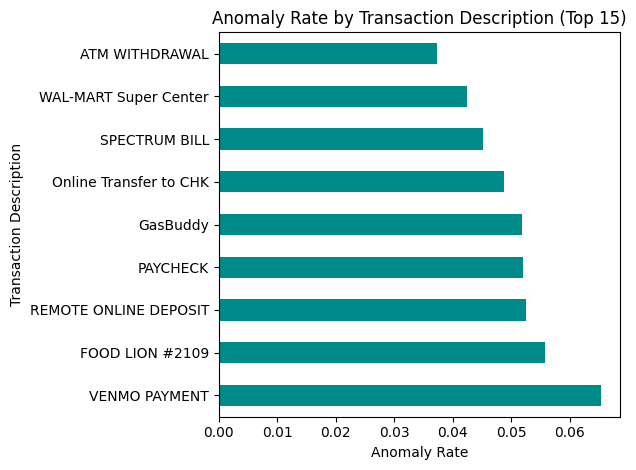

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取文件
df = pd.read_csv("lstm_anomaly_results.csv")

# 确保 is_anomaly 列存在（如果是用 iso_anomaly 也可改）
if 'is_anomaly' not in df.columns and 'iso_anomaly' in df.columns:
    df['is_anomaly'] = (df['iso_anomaly'] == 1).astype(int)

# -------------------------

anomalies = df[df['is_anomaly'] == 1]
category_counts = anomalies['transactionType'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Anomalous Transactions by Category')
plt.xlabel('Transaction Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------------------

desc_total = df['description'].value_counts()
desc_anomalies = df[df['is_anomaly'] == 1]['description'].value_counts()

common_descriptions = desc_total.index.intersection(desc_anomalies.index)
anomaly_rate = (desc_anomalies[common_descriptions] / desc_total[common_descriptions]).sort_values(ascending=False)


top_anomaly_rate = anomaly_rate.head(15)

top_anomaly_rate.plot(kind='barh', color='darkcyan')
plt.title('Anomaly Rate by Transaction Description (Top 15)')
plt.xlabel('Anomaly Rate')
plt.ylabel('Transaction Description')
plt.tight_layout()
plt.show()


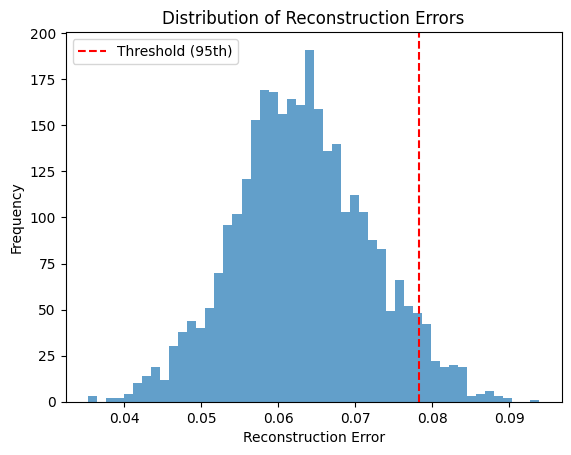

In [70]:
import matplotlib.pyplot as plt

plt.hist(reconstruction_errors, bins=50, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold (95th)')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()


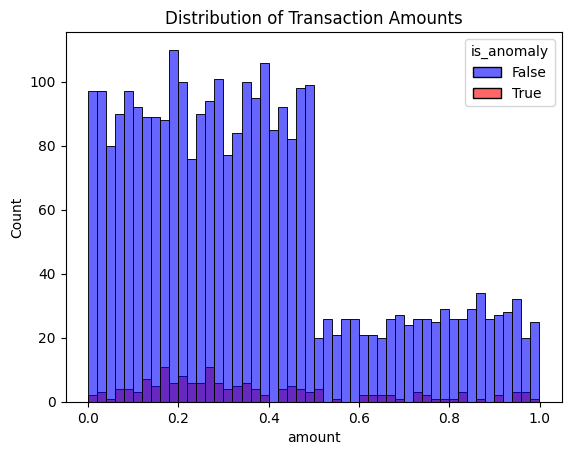

,accountId,description,amount,lstm_recon_error
2064,3958010836,REMOTE ONLINE DEPOSIT,0.656281,0.093897
681,3174162469,WAL-MART Super Center,0.097899,0.090374
4032,3756785627,VENMO PAYMENT,0.120693,0.089348
1686,3483906586,SPECTRUM BILL,0.140902,0.088686
2841,3024293784,VENMO PAYMENT,0.276045,0.088641
2667,3442930865,PAYCHECK,0.746184,0.088206
3453,3337623233,FOOD LION #2109,0.471693,0.088012
2681,3442930865,FOOD LION #2109,0.263612,0.087944
4278,3828810327,SPECTRUM BILL,0.014792,0.087939
1152,3034620484,REMOTE ONLINE DEPOSIT,0.732770,0.087532


In [74]:
# 1. 画出异常和正常的金额分布
sns.histplot(data=merged_df_trimmed, x='amount', hue='is_anomaly', bins=50, palette=['blue', 'red'], alpha=0.6)
plt.title("Distribution of Transaction Amounts")
plt.show()

# 2. 显示最可疑的 10 个交易
top_anomalies = merged_df_trimmed.sort_values(by='lstm_recon_error', ascending=False).head(10)
display(top_anomalies[['accountId', 'description', 'amount', 'lstm_recon_error']])


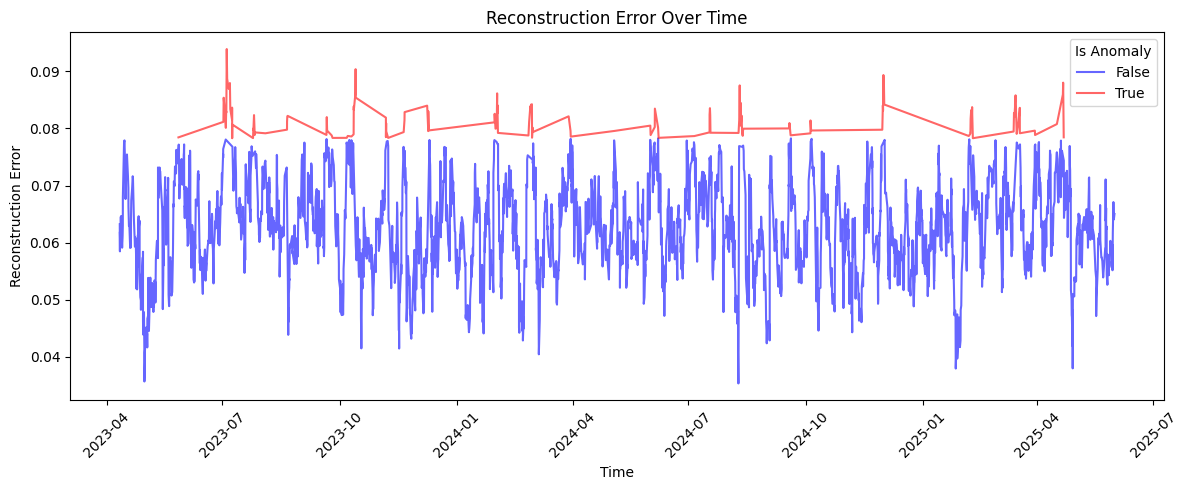

In [76]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_df_trimmed, x='transactionTimestamp', y='lstm_recon_error', hue='is_anomaly', palette=['blue', 'red'], alpha=0.6)
plt.title("Reconstruction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.legend(title="Is Anomaly")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [77]:
anomaly_counts = merged_df_trimmed[merged_df_trimmed['is_anomaly'] == 1]['accountId'].value_counts().head(10)
print(anomaly_counts)


accountId
3958010836    5
3094650185    4
3452811916    4
3442930865    4
3337623233    4
3006860098    4
3828810327    4
3235933793    4
3329416865    4
3174162469    3
Name: count, dtype: int64
